In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Directories
DATA_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\new updates"
TRAIN_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\train_data4"
VAL_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\val_data4"
TEST_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\test_data4"
IMG_SIZE = (224, 224)  # DenseNet201 input size
BATCH_SIZE = 16
EPOCHS = 20
MAX_IMAGES_PER_CLASS = 10000

# Dataset Preparation
def prepare_dataset(data_dir, train_dir, val_dir, test_dir, max_images_per_class, train_split=0.7, val_split=0.15):
    for dir_path in [train_dir, val_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:max_images_per_class]
            train_images, test_images = train_test_split(images, train_size=train_split + val_split, random_state=42)
            val_images, test_images = train_test_split(test_images, train_size=val_split / (1 - train_split), random_state=42)

            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            for image in train_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(train_class_dir, image))
            for image in val_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(val_class_dir, image))
            for image in test_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(test_class_dir, image))

# Check if the directory exists
print("Does DATA_DIR exist?", os.path.exists(DATA_DIR))

# If it does not exist, print an error message
if not os.path.exists(DATA_DIR):
    print("Error: DATA_DIR does not exist! Please check the folder path.")

# Call the function
prepare_dataset(DATA_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR, MAX_IMAGES_PER_CLASS)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=50.0
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Does DATA_DIR exist? True
Found 12639 images belonging to 3 classes.
Found 1114 images belonging to 3 classes.
Found 1118 images belonging to 3 classes.


In [3]:

# Model Definition
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in base_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(
    filepath=os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", "densenet201_model_epoch_{epoch:02d}.keras"),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
csv_logger = CSVLogger(os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", 'densenet201_training_log.csv'))
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, csv_logger, lr_scheduler, early_stopping]
)

# Save the Final Model
model.save(os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", "densenet201_final_model.keras"))


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 534s 7us/step


c:\Users\farah\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1151s 1s/step - accuracy: 0.5637 - loss: 8.8477 - val_accuracy: 0.6885 - val_loss: 4.2947 - learning_rate: 1.0000e-04
Epoch 2/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1182s 1s/step - accuracy: 0.6694 - loss: 3.8583 - val_accuracy: 0.7056 - val_loss: 2.6239 - learning_rate: 1.0000e-04
Epoch 3/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1143s 1s/step - accuracy: 0.6963 - loss: 2.4135 - val_accuracy: 0.7038 - val_loss: 1.7894 - learning_rate: 1.0000e-04
Epoch 4/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1123s 1s/step - accuracy: 0.7093 - loss: 1.6471 - val_accuracy: 0.7083 - val_loss: 1.3288 - learning_rate: 1.0000e-04
Epoch 5/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1122s 1s/step - accuracy: 0.7376 - loss: 1.2059 - val_accuracy: 0.7307 - val_loss: 1.0495 - learning_rate: 1.0000e-04
Epoch 6/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1126s 1s/step - accuracy: 0.7578 - loss: 0.9631 - val_accuracy: 0.7307 - val_loss: 0.9019 - learning_rate: 1.0000e-04
Epoch 7/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1107s 1s/ste

70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8268 - loss: 0.4992
Densenet201 Test Accuracy: 0.77
70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step


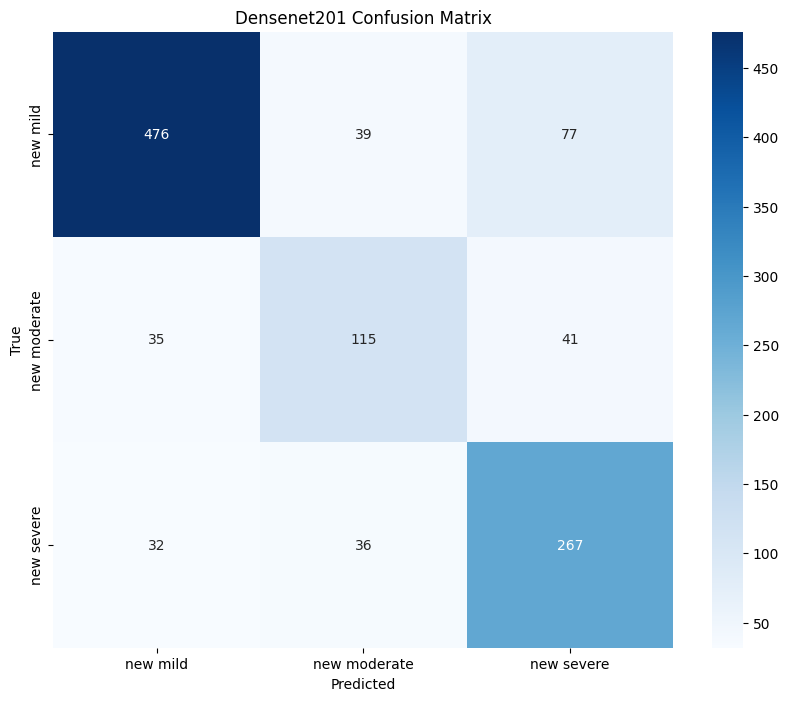

              precision    recall  f1-score   support

    new mild       0.88      0.80      0.84       592
new moderate       0.61      0.60      0.60       191
  new severe       0.69      0.80      0.74       335

    accuracy                           0.77      1118
   macro avg       0.73      0.73      0.73      1118
weighted avg       0.78      0.77      0.77      1118



In [4]:
# Evaluate the Model
test_gen.reset()
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Densenet201 Test Accuracy: {test_accuracy:.2f}")

# Predictions and Metrics
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.title("Densenet201 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))